In [30]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
np.seterr(divide='ignore', invalid='ignore')
import random
from tqdm import tqdm
import math

# Image manipulation.
import PIL.Image
from scipy.ndimage.filters import gaussian_filter

In [31]:
tf.__version__

'0.12.0'

In [32]:
import inception5h 
# inception.data_dir = 'inception/5h/'

In [33]:
inception5h.maybe_download()

Data has apparently already been downloaded and unpacked.


In [34]:
model = inception5h.Inception5h()

In [35]:
len(model.layer_tensors)

12

In [36]:
#Helper functions for messing with the image 
def load_image(filename):
    image = PIL.Image.open(filename)
    #returns a np.float32 version of the image 
    return np.float32(image)

In [37]:
def save_image(image,filename):
    #need to make sure that pixle values are between 0 and 225 
    image = np.clip(image,0.0,255.0)
    #Converting to bytes 
    image = image.astype(np.unit8)
    #write the image 
    with open(filename,'wb') as file: 
        PIL.Image.fromarray(image).save(file,'jpeg')

In [38]:
def plot_image(image):
    #ensure pixles are between 0 and 225 
    image = np.clip(image,0.0,225.0)
    #convert to bytes 
    image = image.astype(np.uint8)
    #display the image
    display(PIL.Image.fromarray(image))

In [39]:
def normalize_image(x): 
    #get the biggest and smallest values from the pixles 
    _min = x.min()
    _max = x.max()
    
    #we want all numbers to be between 0-1
    _norm = (x-_min)/(_max - _min)
    return _norm

In [40]:
def plot_gradient(gradient): 
    #normalize the gradient 
    gradient_norm = normalize_image(gradient)
    
    #show what we normalized 
    plt.imshow(gradient_norm, interpolation='bilinear')
    plt.show()

In [41]:
def resize_image(image, size=None, factor=None):
    if factor is not None: 
        #scale the numpy array's shate for height and width 
        size = np.array(image.shape[0:2]) * factor 
        #PIL reqires integers 
        size = size.astype(int)
    else:
        size = size[0:2]
    
    #height and width is oppositve in numpy then in PIL 
    size = tuple(reversed(size))
    #ensure pixles are between 0 and 225
    img = np.clip(image, 0.0,225.0)
    #convert to bytes 
    img = imag.astype(np.uint8)
    #create pil object 
    image= PIL.Image.fromarray(img)
    
    #resize the image 
    image_resize = img.resize(size,PIL.Image.LANCZOS)
    
    image_resize = np.float32(image_resize)
    return image_resize
        

In [43]:
def get_tile_size(num_pixles,tile_size=400):
    #how many tiles can we create
    num_tiles = int(round(num_pixles/tile_size))
    #ensure at least 1 tile 
    num_tiles = max(1,num_tiles)
    
    actual_tile_size = math.ceil(num_pixles / num_tiles)
    
    return actual_tile_size 

In [44]:
def tiled_gradient(gradient, image, tile_size=400):
    #allocate an array for the gradient of the image 
    grad = np.zeros_like(image)
    
    #number of pixles for the x- and y- axis 
    x_max, y_max, _ = image.shape
    #tile size for x-axis 
    x_tile_size = get_tile_size(num_pixles=x_max, tile_size=tile_size)
    #1/4 of the tile size 
    x_tile_size4 = x_tile_size // 4 
    
    #tile size for y-axis 
    y_tile_size = get_tile_size(num_pixles=y_max, tile_size=tile_size)
    y_tile_size4 = y_tile_size // 4
    
    #random the start position for the tiles on the x-axis 
    x_start = random.randint(-3*x_tile_size4, -x_tile_size4)
    
    while x_start < x_max: 
        #end position for current tile
        x_end = x_start+x_tile_size
        
        #ensure that the tiles start and end positions are valid 
        x_start_lim = max(x_start, 0) 
        x_end_lim = min(x_end, x_max)
        
        #random the start position for the tiles on the y-axis 
        y_start = random.randint(-3*y_tile_size4, -y_tile_size4)
        
        while(y_start <y_max):
            y_end = y_start * y_tile_size
            #ensure that the values are valid 
            y_start_lim = max(y_start,0)
            y_end_lim = min(y_end, y_max)
            
            #get the actual image tile
            img_tile = image[x_start_lim:x_end_lim, y_start_lim:y_end_lim, :]
                    
            #create a feed-dict so we can actually pass it through tensorflow 
            feed_dict = model.create_feed_dict(image=img_tile)
            
            #use tensorflow to calculate the gradient-value 
            g = session.run(gradient, feed_dict=feed_dict)
            
            #normalize the gradient for the tile 
            g /= (np.std(g) + 1e-8)
            grad[x_start_lim:x_end_lim, y_start_lim:y_end_lim, :] = g 
            y_start = y_end 
        x_start = x_end
    return grad

In [45]:
def optimize_image(layer_tensor, image, num_iterations=10, step_size=3.0, tile_size=400, show_gradient=False):
    #take a layer_tensor (that we want to be maximised) and a image, and a step_size for the gradient, 
    # and if we want to show the gradient 
    img = image.copy()
    print("Image before:")
    plot_image(img)
    
    print("Processing Image:", end="")
    #get the gradient from the spesific layer to the input image (called from the inception5h.py)
    #uses tf.gradients to calcualte the gradient after we square the tensor 
    gradient = model.get_gradient(layer_tensor)
    
    for i in tqdm(range(num_iterations)): 
        grad = tiled_gradient(gradient=gradient, image=img)
        
        sigma = (i * 4.0) / num_iterations + 0.5
        grad_smooth1 = gaussian_filter(grad, sigma=sigma)
        grad_smooth2 = gaussian_filter(grad, sigma=sigma*2)
        grad_smooth3 = gaussian_filter(grad, sigma=sigma*0.5)
        grad = (grad_smooth1 + grad_smooth2 + grad_smooth3)
        
        step_size_scaled = step_size / (np.std(grad) + 1e-8)
        
        image += grad * step_size_scaled
        if show_gradient:
            # Print statistics for the gradient.
            msg = "Gradient min: {0:>9.6f}, max: {1:>9.6f}, stepsize: {2:>9.2f}"
            print(msg.format(grad.min(), grad.max(), step_size_scaled))

            # Plot the gradient.
            plot_gradient(grad)
        else:
            # Otherwise show a little progress-indicator.
            print(". ", end="")

    print()
    print("Image after:")
    plot_image(img)
    
    return img
    

In [46]:
def recursize_optimizer(layer_tensor, image, num_repeates=4, rescale_factor=0.7, blend=0.2,
                        num_iterations=100, step_size=3.0, tile_size=400):
    if num_repeates>0: 
        #blur the input image to prevent artifacts when downscaling 
        sigma = 0.5
        img_blur = gaussian_filter(image, sigma=(sigma, sigma, 0.0))
        
        #downscale the image 
        img_downscale = resize_image(image=img_blur, factor=rescale_factor)
        
        
        #recursivly call the function, subtracting 1 from numrepeates
        img_result = recursive_optimize(layer_tensor=layer_tensor,
                                        image=img_downscaled,
                                        num_repeats=num_repeats-1,
                                        rescale_factor=rescale_factor,
                                        blend=blend,
                                        num_iterations=num_iterations,
                                        step_size=step_size,
                                        tile_size=tile_size)
        #upscale the image 
        img_upscale = resize_image(image=img_result, size=image.shape)
        
        #blend the original and processed image 
        image = blend * image + (1.0 - blend) * img_upscale
    print("Recursive Level: ", num_repeates)
    
    
    #process the image using the deep dream algorithum 
    
    img_result = optimize_image(layer_tensor=layer_tensor,
                                image=image,
                                num_iterations=num_iterations,
                                step_size=step_size,
                                tile_size=tile_size)
    return img_result 
        

In [47]:
session = tf.InteractiveSession(graph=model.graph)

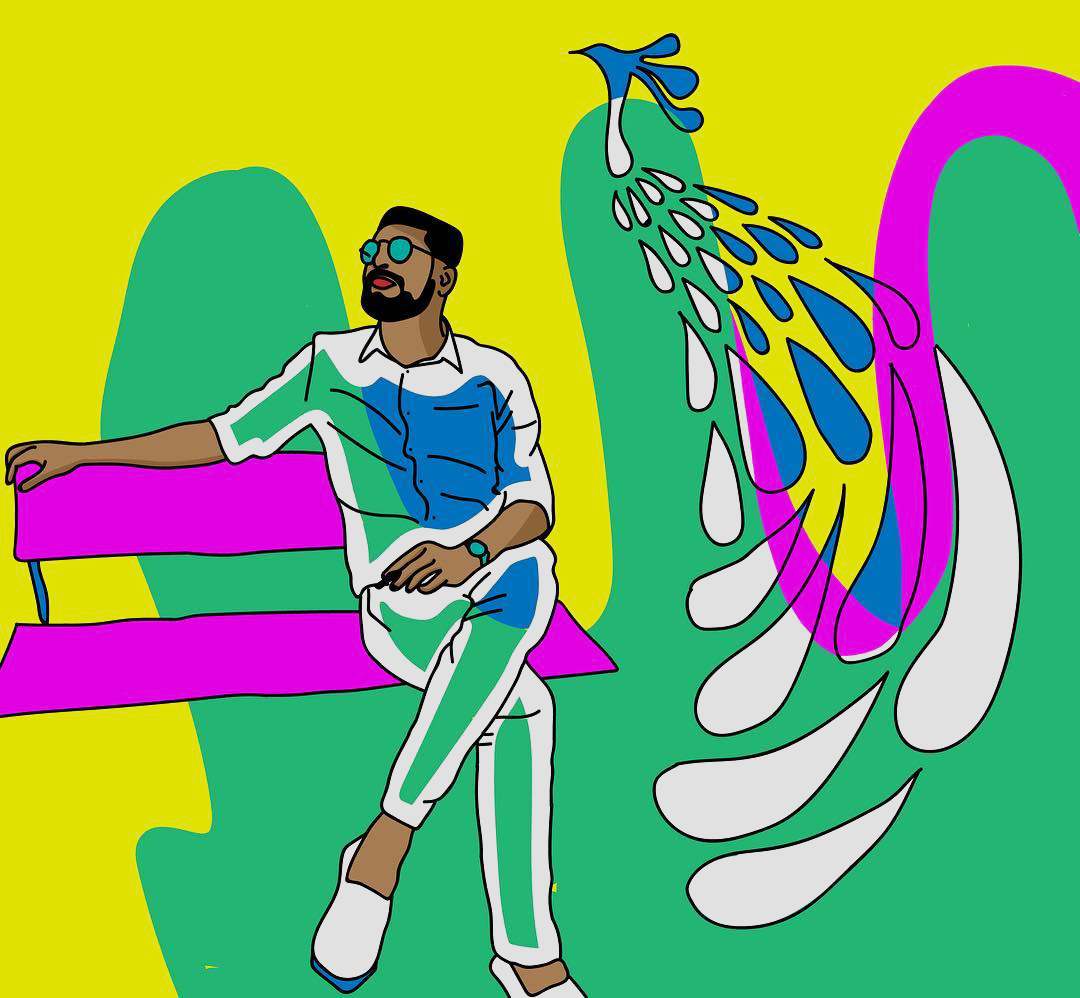

In [48]:
image = load_image(filename='img/s1.jpg')
plot_image(image)

In [49]:
layer_tensor = model.layer_tensors[2]
layer_tensor

<tf.Tensor 'conv2d2:0' shape=(?, ?, ?, 192) dtype=float32>

Image before:


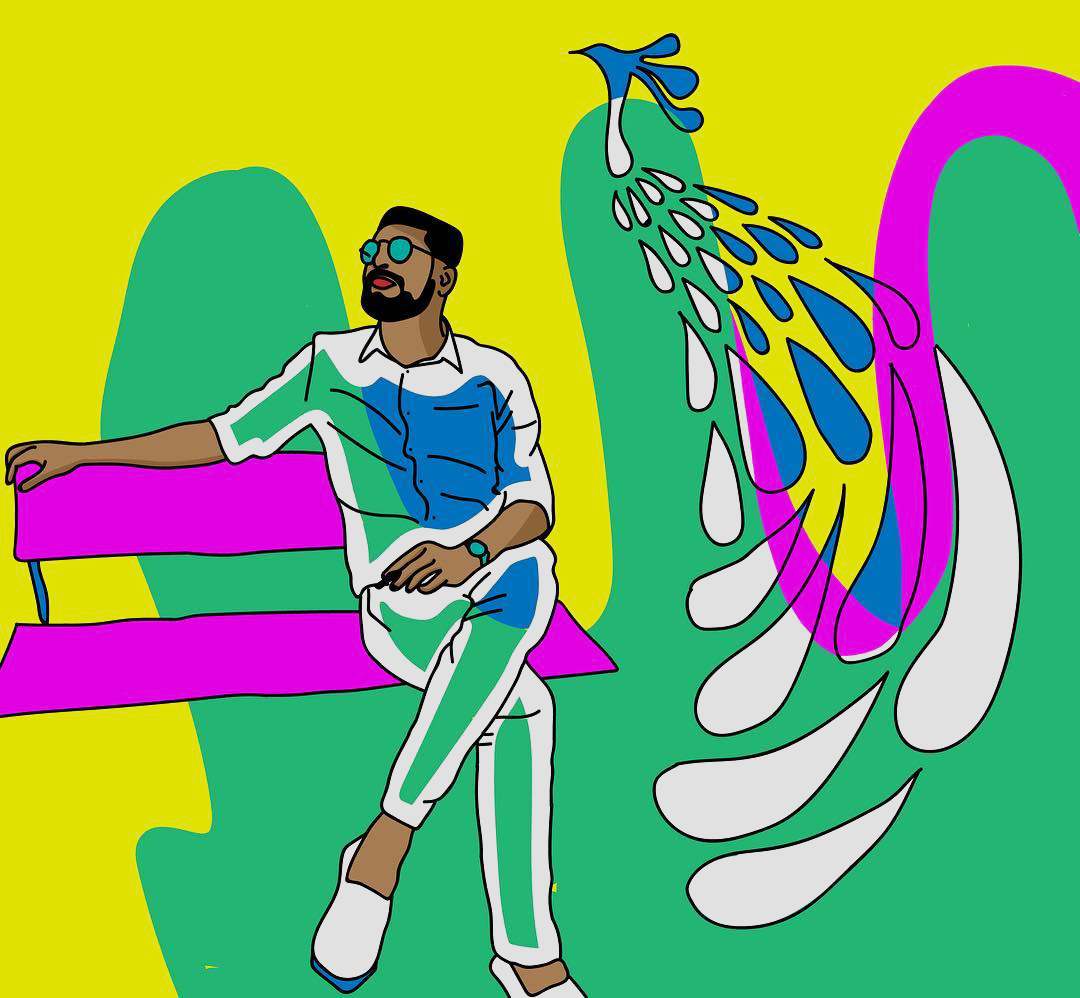

Processing Image:

  0%|          | 0/10 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [50]:
img_result = optimize_image(layer_tensor, image,
                   num_iterations=10, step_size=6.0, tile_size=400,
                   show_gradient=True)